In [1]:
import sys

sys.path.append("D:\code\pywfn")

from pywfn.data import sphGrid
from pywfn.base import Mol
from pywfn.reader import LogReader
from pywfn.atomprop import atomCharge

import matplotlib.pyplot as plt
import pyvista as pv
import numpy as np
import time
from sys import getsizeof

In [2]:
weight = sphGrid.gridData[:, -1]
coords = sphGrid.gridData[:, :3]
coords.setflags(write=False)

path = "D:\BaiduSyncdisk\Articles\HFV\gfile\CH4\CH4_STO3.out"
# path="D:\BaiduSyncdisk\gfile\elements\H2.out"
# path="D:\BaiduSyncdisk\gfile\C=C\CH2=CH2.out"
reader=LogReader(path)
mol = Mol(reader)
mol.bohr = True
atms = mol.obtAtms
shls = mol.obtShls
syms = mol.obtSyms

lmns = [mol.basis.sym2lmn(sym) for sym in syms]

nmat = mol.CM.shape[0]
npos=len(weight)
nobt = len(mol.O_obts)
obts = mol.O_obts
nmat

9

In [3]:
from matplotlib import colormaps
len(list(colormaps))

170

## 定义函数

In [4]:
def get_wfn(i:int,pos:np.ndarray):
    """
    第i个原子轨道的波函数,pos为空间坐标
    """
    lmn = lmns[i]
    atm = atms[i]
    shl = shls[i]
    ang = sum(lmn)
    atmic = mol.atom(atm).atomic
    basis = mol.basis.get(atmic, shl, ang)
    exps = [b.exp for b in basis]
    coes = [b.coe for b in basis]
    pos_ = pos-mol.atom(atm).coord # 空间坐标-原子坐标=以原子为中心的空间坐标
    R2 = np.sum(pos_**2, axis=1)
    wfn = mol.gto.cgf(exps, coes, lmn, R2, pos_)  # 空间坐标-以原子为中心的坐标
    return wfn

def mol_den(pos):
    """计算分子的电子密度"""
    molDens=np.zeros(npos)
    for u in range(nmat):
        wfn_u=get_wfn(u,pos)
        for v in range(nmat):
            wfn_v=get_wfn(v,pos)
            molDens+=wfn_u*wfn_v*mol.PM[u,v]
    return molDens

def get_smi(u, v, pos)->float:  # 重叠矩阵矩阵元
    wfn_u = get_wfn(u,pos)
    wfn_v = get_wfn(v,pos)
    smi = np.sum(wfn_u * wfn_v * weight)
    return smi

def get_pmi(u, v, pos):  # 势能矩阵矩阵元
    wfn_u = get_wfn(u,pos)
    wfn_v = get_wfn(v,pos)
    sr=np.zeros(npos)
    for atom in mol.atoms:
        r=np.linalg.norm(pos-atom.coord,axis=1)
        sr+=atom.atomic/r
    smi = np.sum(wfn_u * sr * wfn_v * weight)
    return smi


In [5]:
[(i,atms[i],s) for i,s in enumerate(syms)]

[(0, 1, 'S'),
 (1, 1, 'S'),
 (2, 1, 'PX'),
 (3, 1, 'PY'),
 (4, 1, 'PZ'),
 (5, 2, 'S'),
 (6, 3, 'S'),
 (7, 4, 'S'),
 (8, 5, 'S')]

In [6]:
diag=[get_smi(i,i,coords)for i in range(nmat)] # 对角线元素，对的
diag

[0.9988429117397326,
 1.0000023598440406,
 1.0000050511542427,
 1.0000050511542427,
 1.0000050511542429,
 1.0000402270316424,
 1.0000402270316426,
 1.0000402270316426,
 1.0000402270316424]

In [7]:
u=4
print(f'-----{atms[u]:>1}.{shls[u]:1}{syms[u]:<3}-----')
for i in range(nmat):
    pu=mol.atom(atms[u]).coord
    pi=mol.atom(atms[i]).coord
    pos=coords+(pu+pi)/2
    smi=get_smi(u,i,pos)
    
    print(f'{atms[i]:>1}.{shls[i]:1}{syms[i]:<3}{smi:>8.4f},{mol.SM[u,i]:>8.4f}')
# 不同原子的非对角元素

-----1.2PZ -----
1.1S    0.0000,  0.0000
1.2S    0.0000,  0.0000
1.2PX   0.0000,  0.0000
1.2PY   0.0000,  0.0000
1.2PZ   1.0000,  1.0000
2.1S    0.2738,  0.2737
3.1S    0.2738,  0.2737
4.1S   -0.2738, -0.2737
5.1S   -0.2738, -0.2737


In [8]:
0.2737**2*4,0.4742**2+0.1581**2*3

(0.29964676, 0.29985247)

## 分子电子密度

In [9]:
# 全部展开求解
molDens=np.zeros(npos)
for o in obts:
    obtDens=np.zeros(npos) # 每个分子轨道的密度
    for u in range(nmat):
        pos=coords+mol.atom(atms[u]).coord # v和u应该使用相同的空间坐标啊
        # pos=coords
        wfn_u=get_wfn(u,pos)
        for v in range(nmat):
            wfn_v=get_wfn(v,pos)
            obtDens+=wfn_u*wfn_v*mol.CM[u,o]*mol.CM[v,o]*2
    print(np.sum(obtDens*weight))
    molDens+=obtDens
np.sum(molDens*weight)

1.9972642423672557
1.9984340824298656
2.0001216566317277
2.0001216566317277
2.000121656631728


9.996063294692306

In [10]:
# 直接使用密度矩阵计算分子电子密度，无法计算整个分子的波函数，因为对于不同原子，所采取的格点位置不同，虽然数量一致，但不能直接相加？
molDens=np.zeros(npos)
basDensl=[]
for u in range(nmat):
    pos=coords+mol.atom(atms[u]).coord # u处原子坐标
    basDens=np.zeros(npos)
    wfn_u=get_wfn(u,pos)
    for v in range(nmat):
        wfn_v=get_wfn(v,pos)
        basDens+=wfn_u*wfn_v*mol.PM[u,v]
    basDensl.append(np.sum(basDens*weight))
    molDens+=basDens
np.sum(molDens*weight)

9.996063294692306

In [11]:
# 每个原子的电子数量
for atom in mol.atoms:
    u,l=atom.obtBorder
    print(sum(basDensl[u:l]))

6.339112038825842
0.9142378139666157
0.9142378139666159
0.9142378139666156
0.9142378139666157


In [12]:
# 先计算出分子轨道波函数，然后求分子轨道密度
molDens=np.zeros(npos)
for o in obts:
    wfn=np.zeros(npos) # 分子轨道的波函数
    for u in range(nmat): # 每一个原子轨道
        pos=mol.atom(atms[u]).coord+coords # 每个原子的中心坐标都不一致
        wfn+=mol.CM[u,o]*get_wfn(u,coords) # 这里的坐标应该使用哪一个？，为什么使用pos不对？整个分子的电子密度，以分子为中心
    obtDens=wfn**2*weight*2 # 分子轨道的电子密度
    molDens+=obtDens
    print(np.sum(obtDens))
print(np.sum(molDens))

1.997726982866233
2.0004281017516528
2.0001424906308642
2.0001424906308647
2.0001424906308647
9.998582556510478


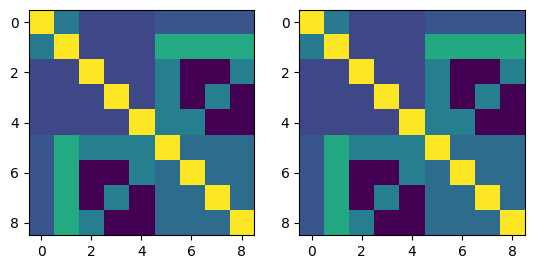

In [13]:
# 数值重叠积分与log重叠积分对比
fig,axs=plt.subplots(1,2)
SM=np.zeros(shape=(nmat,nmat))
for u in range(nmat):
    pu=mol.atom(atms[u]).coord
    for v in range(nmat):
        pv=mol.atom(atms[v]).coord
        pos=coords+(pu+pv)/2
        smi=get_smi(u,v,pos)
        SM[u,v]=smi
axs[0].imshow(SM) # 数值方法算出的重叠积分
axs[1].imshow(mol.SM) # log文件中读出的重叠积分
plt.show()

In [14]:
from pywfn.data import Basis
from pywfn.maths import Gto

def ago(pos,atm,obts):
    R2 = np.sum(pos**2, axis=1)  # x^2+y^2+z^2

    atom = mol.atom(atm)
    u, l = atom.obtBorder
    print(u,l)
    atms = mol.obtAtms[u:l]
    shls = mol.obtShls[u:l]
    syms = mol.obtSyms[u:l]
    lmns = [Basis.sym2lmn(sym) for sym in syms]
    coef = mol.CM[u:l, obts]  # 二维矩阵
    expl = []
    coel = []
    ncsl = []  # 记录每个收缩轨道的大小
    for i in range(len(atms)):  # 该原子的行索引
        lmn = lmns[i]
        atm = atms[i]
        shl = shls[i]
        ang = sum(lmn)
        basis = mol.basis.get(atom.atomic, shl, ang)
        exps = [b.exp for b in basis]
        coes = [b.coe for b in basis]
        expl += exps
        coel += coes
        ncsl.append(len(exps))
    return coef,lmns,ncsl,expl,coel,R2
atom=mol.atom(1)
coef,lmns,ncsl,expl,coel,R2=ago(coords-atom.coord,1,mol.O_obts)
coef.shape,lmns

0 5


((5, 5), [[0, 0, 0], [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [15]:
j = 0
wfns = np.zeros(len(pos), dtype=np.float32)
for i in range(len(lmns)):
    print(i)
    nc = ncsl[i]  # 收缩大小
    lmn = lmns[i]
    coes = coel[j : j + nc]
    exps = expl[j : j + nc]
    j += nc
    wfn = Gto.cgf(exps, coes, lmn, R2, pos) # 每一个原子轨道都是提前定义好的不变的
    for obt in obts:
        wfns += coef[i, obt] * wfn

0
1
2
3
4


In [22]:
from pywfn.spaceProp import wfn
path = "D:\BaiduSyncdisk\Articles\HFV\gfile\CH4\CH4_STO3.out"
# path="D:\BaiduSyncdisk\gfile\elements\H2.out"
# path="D:\BaiduSyncdisk\gfile\C=C\CH2=CH2.out"
reader=LogReader(path)
mol = Mol(reader)
caler=wfn.Calculator(mol)
dens=caler.molDens(coords)
np.sum(dens*weight)

9.998582556510478

In [23]:
caler=wfn.Calculator(mol)
dens=caler.molDens2(coords)
np.sum(dens*weight)

9.99858255651048

In [24]:
for atom in mol.atoms:
    dens=caler.atmDens(atom.idx,coords+mol.atom(1).coord)
    elec=np.sum(dens*weight)
    print(elec)

6.339112038825842
0.9148676294211592
0.9148676294211591
0.9148676294211592
0.9148676294211592


In [25]:
for a1,atom1 in enumerate(mol.atoms):
    pos=coords+atom1.coord #将空间坐标移动到第i原子
    for a2,atom2 in enumerate(mol.atoms):
        dens=caler.atmDens(atom2.idx,pos)
        print(sum(dens*weight))
    print('-'*40)

6.339112038825857
0.9148676294211612
0.9148676294211652
0.9148676294211663
0.914867629421161
----------------------------------------
8.242923871288369
0.9142378139666211
0.9099050889279944
0.9099050889279936
0.9099050889279944
----------------------------------------
8.242923871288369
0.9099050889279946
0.9142378139666149
0.909905088927995
0.9099050889279954
----------------------------------------
8.242923871288374
0.9099050889279942
0.9099050889279964
0.9142378139666141
0.9099050889279946
----------------------------------------
8.242923871288363
0.9099050889279918
0.909905088927994
0.9099050889279937
0.9142378139666179
----------------------------------------


In [20]:
from pywfn.atomprop import atomCharge
caler=atomCharge.Calculator(mol)
caler.hirshfeld()

1.0009,1.0001
1.0008,1.0001
q= -0.015863288547113386
atmQ=1.0009,proQ=2.0017,molQ=2.0002
1.0008,1.0001
1.0009,1.0001
q= -0.015863288547113386
atmQ=1.0009,proQ=2.0017,molQ=2.0002


[-6.374358183247608e-05, -6.374358183247608e-05]

In [45]:
pos=[]
wei=[]
for atom in mol.atoms:
    pos.append(coords+atom.coord)
    wei.append(weight)
pos=np.vstack(pos)
wei=np.hstack(wei)/len(mol.atoms)
wfnCaler=wfn.Calculator(mol)
chars=[]
for _,atom in enumerate(mol.atoms):
    dens=wfnCaler.atmDens(atom.idx,pos)
    char=sum(dens*wei)
    chars.append(char)
chars=np.array(chars)
k=sum(mol.atoms.atomics)/sum(chars)
chars*=k
chars

array([6.83, 0.79, 0.79, 0.79, 0.79])

In [46]:
sum(chars)

10.0